# Prueba de evaluacion. Tratamiento de JSON
#### El primer paso es cargar las librerías necesarias para la ejecuion

In [122]:
import json
import urllib2
import requests as rq
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


Se consulta el catalogo de Boards de la página 4chan y se evalua el tipo de contenido y la respuesta

In [123]:
r = rq.get('https://a.4cdn.org/boards.json')
print r.status_code
print r.headers['content-type']
print r.text[:1000]

200
application/json
{"boards":[{"board":"3","title":"3DCG","ws_board":1,"per_page":15,"pages":10,"max_filesize":4194304,"max_webm_filesize":3145728,"max_comment_chars":2000,"max_webm_duration":120,"bump_limit":310,"image_limit":150,"cooldowns":{"threads":600,"replies":60,"images":60},"meta_description":"\u0026quot;\/3\/ - 3DCG\u0026quot; is 4chan's board for 3D modeling and imagery.","is_archived":1},{"board":"a","title":"Anime \u0026 Manga","ws_board":1,"per_page":15,"pages":10,"max_filesize":4194304,"max_webm_filesize":3145728,"max_comment_chars":2000,"max_webm_duration":120,"bump_limit":500,"image_limit":250,"cooldowns":{"threads":600,"replies":60,"images":60},"meta_description":"\u0026quot;\/a\/ - Anime \u0026amp; Manga\u0026quot; is 4chan's imageboard dedicated to the discussion of Japanese animation and manga.","spoilers":1,"custom_spoilers":1,"is_archived":1},{"board":"aco","title":"Adult Cartoons","ws_board":0,"per_page":15,"pages":10,"max_filesize":4194304,"max_webm_filesize"

Se obtiene el contexto en texto y se transforma en un objeto JSON para navegar com osi fuera un diccionario

In [124]:
boards = json.loads(r.text)
print type(boards)
print(json.dumps(boards, indent=3))

<type 'dict'>
{
   "boards": [
      {
         "max_webm_duration": 120, 
         "meta_description": "&quot;/3/ - 3DCG&quot; is 4chan's board for 3D modeling and imagery.", 
         "cooldowns": {
            "images": 60, 
            "threads": 600, 
            "replies": 60
         }, 
         "title": "3DCG", 
         "is_archived": 1, 
         "max_comment_chars": 2000, 
         "ws_board": 1, 
         "max_filesize": 4194304, 
         "board": "3", 
         "max_webm_filesize": 3145728, 
         "per_page": 15, 
         "bump_limit": 310, 
         "image_limit": 150, 
         "pages": 10
      }, 
      {
         "max_webm_duration": 120, 
         "meta_description": "&quot;/a/ - Anime &amp; Manga&quot; is 4chan's imageboard dedicated to the discussion of Japanese animation and manga.", 
         "cooldowns": {
            "images": 60, 
            "threads": 600, 
            "replies": 60
         }, 
         "title": "Anime & Manga", 
         "spoilers": 

Se definen dos funciones

* add_row: que volcara la informacion de cada post en un registro del dataframe

* iterate_post: que navegara por todos los post de cada thread,y a su vez por cada thread dentro de cada board seleccionado

In [125]:
def add_row(pos):
    if ("replies" in pos) and ("fsize" in pos):
        print(pos["no"])
        title = pos["no"]
        metadesc = int(pos["replies"])
        imagesize = int(pos["fsize"])
        postframe.loc[title] = [ metadesc, imagesize]
        
def iterate_board(df, board):
    url = "http://a.4cdn.org/%s/%s.json"
    size = board["pages"] 
    count = 0
    count_thread = 0
    count_post = 0
    for i in range(size):
        #print(i)
        formated_url = url%(board["board"],i+1)
        temp = rq.get(formated_url)
        #print(formated_url)
        page = json.loads(temp.text)
        #print(json.dumps(page, indent=2))
        #print(len(page["threads"]))
        for trh in page["threads"]:
            count_thread = count_thread+ 1
            #print( "hilo", count_thread)
            for post in trh["posts"]:
                count_post += 1
                #print( "post", count_post)
                number = int(post["no"])
                replies = 0
                fsize = 0
                name = post["name"]
                com = ""
                bo = board["board"]
                if ("com" in post):
                    com = post["com"]
                if ("replies" in post):
                    replies = int(post["replies"])
                if ("fsize" in post):
                    fsize = int(post["fsize"])
                df.loc[number] = [bo,replies,fsize,name,com]

Seleccionamos los 2 boards iniciales de la consulta.
Los iteramos para generar el dataframe final

In [126]:
board0= boards["boards"][0]
board1= boards["boards"][1]

#creamos el data frame a explorar
postframe = pd.DataFrame(columns=["board","replies", "fsize","name","com",])

#Completamos el dataframe con todos los post de boar1
iterate_board(postframe, board0)
iterate_board(postframe, board1)

In [127]:
postframe.size
postframe.head(5)

,board,replies,fsize,name,com
248019,3,73.0,3277.0,Anonymous,So I was cleaning up my hard drive and I found...
248425,3,0.0,59371.0,Anonymous,
536342,3,12.0,75605.0,Anonymous,Did VR fizzle or what? Trying to decide if I s...
536360,3,0.0,0.0,Anonymous,"<a href=""#p536357"" class=""quotelink"">&gt;&gt;5..."
536857,3,0.0,0.0,Anonymous,"<a href=""#p536342"" class=""quotelink"">&gt;&gt;5..."


Consideraremos los post con replies!=0 y fsize!=0 ya que afectaria a la distribucion de ambas variables. 

Los post de respuesta a algunos post no contienen datos ni de numero de respuestas ni de tamños de ficheros, por lo que tendremos que filtrar el dataset global para revisar estos datos.

In [128]:
df_filtered = postframe.loc[(postframe['replies']>0)]
df_filtered = df_filtered.loc[(df_filtered['fsize']>0)]
df_filtered.size

1390

Revisamos la media para el primero de los boards.

Parece que la media de respuestas en el board '3' está en torno a 24 respuestas por topic

In [129]:
pd.DataFrame.describe(df_filtered[df_filtered['board']=='3'])

,replies,fsize
count,138.00000,1.380000e+02
mean,24.42029,4.465459e+05
std,52.82153,7.048014e+05
min,1.00000,3.277000e+03
25%,4.00000,4.061975e+04
50%,11.00000,1.699465e+05
75%,21.00000,5.246382e+05
max,329.00000,3.716663e+06


Sin embargo para el segundo board, parece que la media de respuestas es mucho mayor, en torno a 126

In [130]:
pd.DataFrame.describe(df_filtered[df_filtered['board']=='a'])

,replies,fsize
count,140.000000,1.400000e+02
mean,126.500000,5.766880e+05
std,151.441206,7.923190e+05
min,1.000000,6.496000e+03
25%,12.750000,8.966150e+04
50%,48.500000,2.432715e+05
75%,215.000000,7.294280e+05
max,521.000000,3.893418e+06


In [90]:
m(dfplot[dfplot['board']=='a']['fsize'])

3893418.0

Ploteamos la distribucion del tamaño de los ficheros para los post del primer board. Parece que no siguen una distribución normal, puesto que la mayoria están entre los 5000 y 10000 bytes.

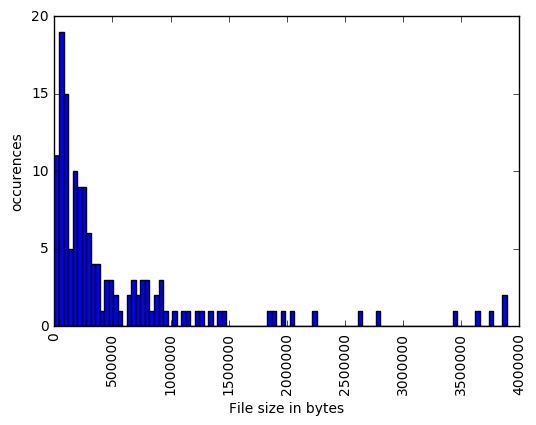

In [111]:
dfplot = df_filtered.reset_index()
counts, bins, patches = plt.hist(dfplot[dfplot['board']=='a']['fsize'],range=(min(dfplot[dfplot['board']=='a']['fsize']), max(dfplot[dfplot['board']=='a']['fsize'])), bins=100)
#plt.set_xticks(bins)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.ylabel('occurences')
plt.xlabel('File size in bytes')

